<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/pattern4_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ④signalシートのSV  KOMA1～KOMA7<br>
## 主食KOMA1     副菜KOMA2    主菜KOMA3	    乳類KOMA4	   果物KOMA5   	菓子類KOMA6	  酒類KOMA7
主食、副菜、主菜、牛乳・乳製品、果物という5つの料理区分において、「どれだけ食べたらよいか」の目安は「つ（SV）」という単位で示される<br>SV:サービング（料理の量の単位）の略で、食事バランスガイド独自の考え方

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Google Colabにlingamのライブラリをインストールする
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


##  関数を定義

In [17]:
# 前処理用（結合、重複削除、NA削除）
def preprocess(df1, df2):
  # df1, df2の重複を確認
  print(f"ID1に重複のある行数\tdf1:{df1['ID1'].duplicated(keep=False).sum()}\tdf2:{df2['ID1'].duplicated(keep=False).sum()}")

  # df2からID1の重複を除去
  df2_cleaned = df2.drop_duplicates(subset='ID1', keep=False)

  # 左結合
  merged_data = pd.merge(df1, df2_cleaned, on='ID1', how='left')

  # 結合後のデータフレームのID1の重複を削除
  merged_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
  print(f"結合後のデータ数:{len(merged_data)}")

  ## エネルギー補正係数とBMIを作成
  # merged_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
  merged_data_copy = merged_data.copy()

  # 新しい列を追加(ECF:Energy correction facto(エネルギー補正係数))
  merged_data_copy['BMI'] = merged_data_copy['BW'] / ((merged_data_copy['BH'] / 100) ** 2)

  # 変数を選択
  selected_columns = merged_data_copy.loc[:, 'KOMA1':'KOMA7'].copy()
  selected_columns['BMI'] = merged_data_copy['BMI']
  selected_columns['AGE'] = merged_data_copy['AGE']
  selected_columns['SEX'] = merged_data_copy['SEX']

  # NA処理
  print(f"NAを含むデータ数:{selected_columns[selected_columns.isna().any(axis=1)].shape[0]}")
  selected_columns_cleaned = selected_columns.dropna()
  selected_columns_cleaned.describe()
  display(selected_columns_cleaned.describe())

  print(f"処理後のデータ数:{len(selected_columns_cleaned)}")

  return selected_columns_cleaned

In [4]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [5]:
# 特定の変数と他の変数との相関を確認
def targetCorrMatrix(df):
  df = 'VEG3'
  correlations = df.corrwith(df[df])
  correlations.sort_values(ascending=False)

In [6]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [7]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [8]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [9]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [10]:
def boxplot(df):
  # dfのすべての列に対して箱ひげ図を描画
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df)
  plt.title("Boxplot of df")
  plt.show()

In [11]:
# 与えられたデータフレームの変数を見る
def checksVariables(df):
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # # 各変数の分布を確認
  # distribution(df)
  # 箱ひげ図を描画
  # boxplot(df)

In [12]:
# 解析に使用するデータフレームを返す
def select_variables(df,columns):
    # 解析に使用する変数のデータフレームを作成
    df = df[columns]

    # 基本統計量の確認
    # print(f"データ数:{len(df)}")
    # display(df.describe())

    # # 各列について、上:0.05%,下:0.05%のデータを外れ値として除去
    # for column in df.columns:
    #     lower_limit = df[column].quantile(0.005)
    #     upper_limit = df[column].quantile(0.995)
    #     df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # # 修正されたデータフレームを確認
    # print(f"上:0.05%,下:0.05%を除去後のデータ数:{len(df)}")
    # display(df.describe())

    return df

In [13]:
# 3σ法による外れ値の除去(正規分布)
def remove_outliers_3sigma(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# IQRによる外れ値の除去
def remove_outliers_iqr(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# # 使い方
# columns_to_process = ['A', 'B']
# df_cleaned_3sigma = remove_outliers_3sigma(df, columns_to_process)
# df_cleaned_iqr = remove_outliers_iqr(df, columns_to_process)

## データ準備

In [2]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


In [14]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_signal = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (signal).csv')

In [15]:
print(len(data_signal),len(data_nutr))

3346 3329


In [18]:
# 前処理（結合、重複削除、NA削除）
preprocessed_df = preprocess(data_signal,data_nutr)

ID1に重複のある行数	df1:134	df2:116
結合後のデータ数:3212
NAを含むデータ数:10


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,KOMA7,BMI,AGE,SEX
count,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000
mean,4.294365,5.256992,7.960230,1.784571,0.850683,2.962818,0.852380,22.313184,47.709869,1.605871
std,1.663748,2.707049,3.087344,1.641892,0.763708,1.942048,1.818285,3.648765,22.889227,0.488739
min,0.280320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516,10.000000,1.000000
25%,3.085925,3.411741,5.792025,0.514033,0.279521,1.541204,0.000000,19.735976,25.000000,1.000000
50%,4.109877,4.813307,7.564622,1.523493,0.647342,2.659966,0.000000,21.958811,53.000000,2.000000
75%,5.284650,6.627483,9.700675,2.504225,1.210074,3.961218,0.661117,24.444444,67.000000,2.000000
max,12.194364,21.371829,22.938361,16.459607,5.809695,13.377456,16.022896,50.781250,96.000000,2.000000


処理後のデータ数:3202


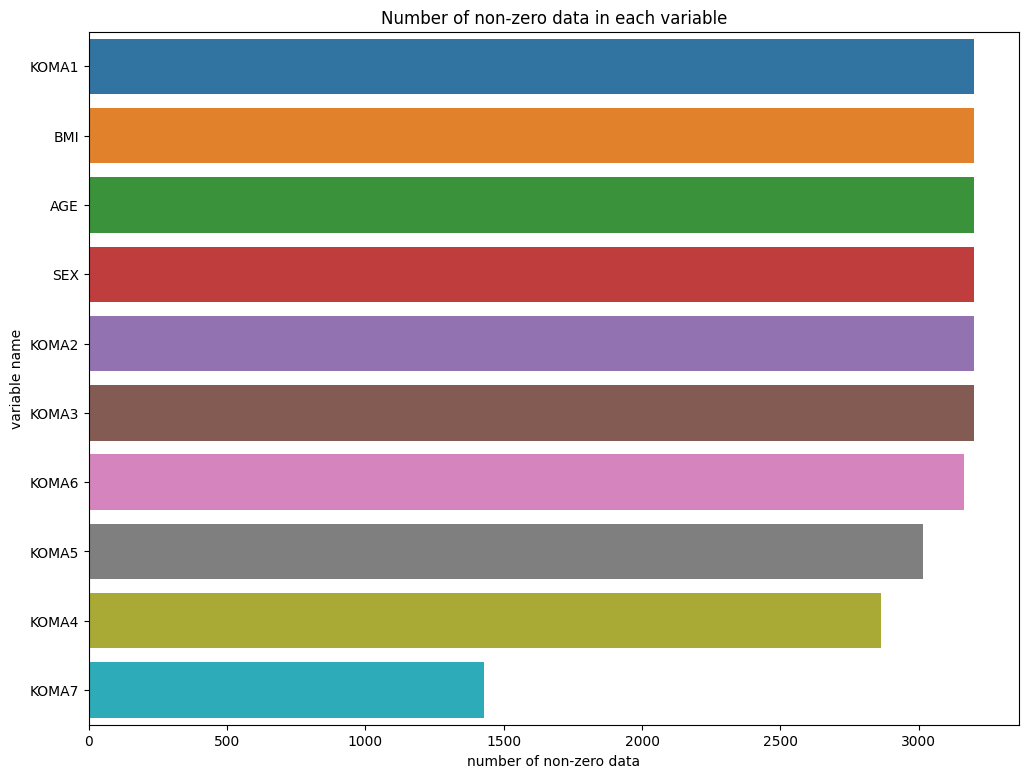

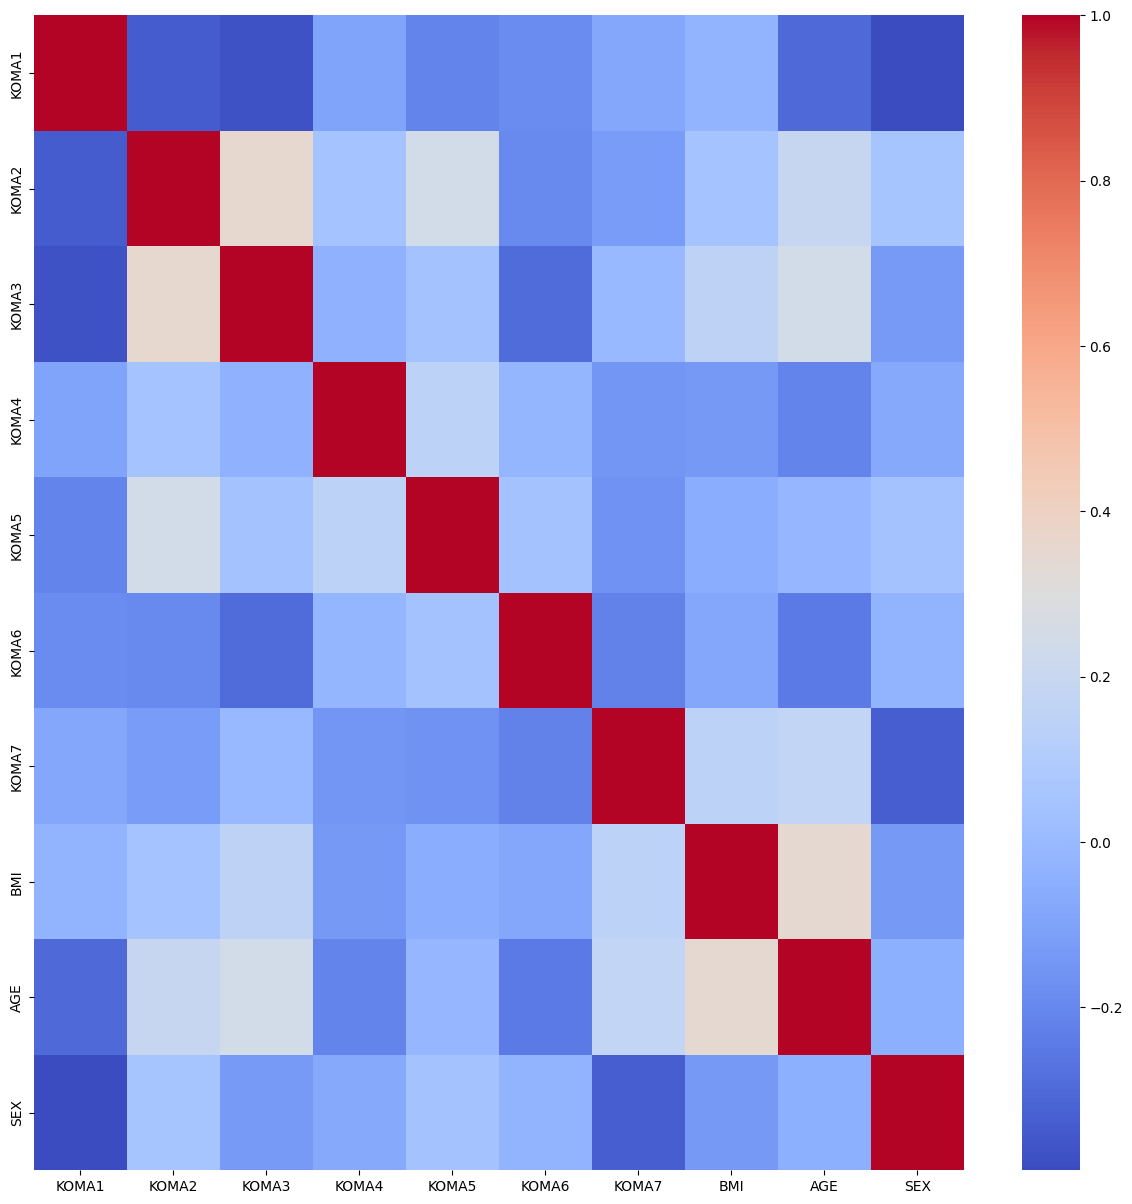

In [19]:
# 変数の相関を確認
checksVariables(preprocessed_df)

In [30]:
# 使用する変数を選択
columns_for_lingam = ['KOMA1', 'KOMA2', 'KOMA3', 'KOMA4', 'KOMA5', 'KOMA6', 'BMI','SEX','AGE']
variables_df = preprocessed_df[columns_for_lingam]
len(variables_df)

3202

In [31]:
def ecf_outliers_process(df):
  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  # df = df[(df != 0).all(axis=1)]

  return df[columns_to_process]

In [32]:
# signal_data_list <- 全体データ、男性群、女性群
signal_data_list = []
signal_data_list.append(ecf_outliers_process(variables_df.drop(['SEX'], axis=1)))
signal_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))
signal_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))

In [33]:
for x in signal_data_list:
  display(x.describe())
  print(len(x))

,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000,3202.000000
mean,4.294365,5.256992,7.960230,1.784571,0.850683,2.962818,22.313184
std,1.663748,2.707049,3.087344,1.641892,0.763708,1.942048,3.648765
min,0.280320,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516
25%,3.085925,3.411741,5.792025,0.514033,0.279521,1.541204,19.735976
50%,4.109877,4.813307,7.564622,1.523493,0.647342,2.659966,21.958811
75%,5.284650,6.627483,9.700675,2.504225,1.210074,3.961218,24.444444
max,12.194364,21.371829,22.938361,16.459607,5.809695,13.377456,50.781250


3202


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,5.112964,5.085182,8.471729,1.932386,0.808168,3.036307,22.924202
std,1.751610,2.831838,3.406685,1.868599,0.786526,2.123801,3.804744
min,0.625587,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917
25%,3.958203,3.190650,6.103614,0.362641,0.233669,1.407860,20.324438
50%,4.928029,4.585163,8.030975,1.672361,0.566652,2.639115,22.835125
75%,6.189353,6.371202,10.380851,2.746889,1.158507,4.148951,25.217359
max,12.194364,21.371829,22.938361,16.375216,5.809695,12.342547,42.134301


1262


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
count,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000
mean,3.761854,5.368758,7.627491,1.688415,0.878340,2.915012,21.915708
std,1.361793,2.617380,2.811918,1.468386,0.747399,1.813039,3.487582
min,0.280320,0.595183,0.824727,0.000000,0.000000,0.000000,12.326516
25%,2.812747,3.543170,5.664876,0.616324,0.310334,1.609805,19.531250
50%,3.647749,4.909638,7.261523,1.488163,0.705147,2.668302,21.403092
75%,4.558681,6.707179,9.322532,2.293266,1.242511,3.872652,23.739956
max,9.225698,18.612653,21.076951,16.459607,5.665657,13.377456,50.781250


1940


### LiNGAMの関数定義

In [34]:
def model_DirectLiNGAM(df,dagname):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(df)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果順序
  print(f"因果の順番\n{model.causal_order_}\n\n_________")

  # 隣接行列
  print("隣接行列\n")
  display(model.adjacency_matrix_)
  print("\n")

  # 因果グラフ
  dot = make_dot(
      model.adjacency_matrix_,
      labels = df.columns.to_list(),
      lower_limit = 0.01)
  display(dot)
  dot.format = 'png'
  dot.render(dagname)

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  display(p_values)

  return model

In [35]:
def model_MultiDirectLiNGAM(df_list):
  # 標準化
  scaler = StandardScaler()
  Xy_list = []
  for df in df_list:
    Xy_list.append(scaler.fit_transform(df))

  # モデル作成
  model = lingam.MultiGroupDirectLiNGAM(random_state=1)
  model.fit(Xy_list)

  for index in range(len(Xy_list)):
    # 因果順序
    print(f"因果順序\n{model.causal_order_}\n\n")

    # 隣接行列
    print(f"隣接行列")
    display(model.adjacency_matrices_[index])
    print("\n")

    # 因果グラフの表示と保存
    dot = make_dot(model.adjacency_matrices_[index],
            labels = df_list[index].columns.to_list(),
            lower_limit = 0.01)
    display(dot)
    dot.format = 'png'
    dagname = f"signal_Direct{index}"
    dot.render(dagname)

    # 因果モデルにおける誤差同士の独立性のp値
    p_values = model.get_error_independence_p_values(df_list)
    display(p_values[index])

  # return model

In [36]:
def model_bootstrap(df, n_sampling):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, n_sampling, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    df_ = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    df_['from'] = df_['from'].apply(lambda x: labels[x])
    df_['to'] = df_['to'].apply(lambda x: labels[x])
    return df_

In [37]:
def model_MultiBootstrap(df_list, n_sampling):
    # 標準化
    scaler = StandardScaler()
    Xy_list = []
    for df in df_list:
      Xy_list.append(scaler.fit_transform(df))

    # モデル作成
    model = lingam.MultiGroupDirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy_list, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # 各グループの結果を表示
    for idx in range(len(Xy_list)):
      print(f"signal_bootstrap_{idx}=============================================")
      # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
      cdc = result[idx].get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("因果方法top10")
      print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())
      print()

      # カウント結果を確率として、隣接行列の形式で表示(表として表示したいがうまくいかないのでそのまま)
      prob = result[idx].get_probabilities(min_causal_effect=0.01)
      colsname = df_list[idx].columns.tolist()
      prob = pd.DataFrame(prob, columns=colsname, index=colsname)
      print("カウント確率")
      display(prob)
      print()

      # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
      dagc = result[idx].get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("DAGのカウント結果")
      print_dagc(dagc, n_sampling, labels=df.columns.to_list())
      print()

      # Total Causal Effects
      causal_effects = result[idx].get_total_causal_effects(min_causal_effect=0.01)

      # Assign to pandas.DataFrame for pretty display
      df_ = pd.DataFrame(causal_effects)
      labels = df_list[idx].columns.to_list()
      # 'from' 列と 'to' 列のラベルを適用する
      df_['from'] = df_['from'].apply(lambda x: labels[x])
      df_['to'] = df_['to'].apply(lambda x: labels[x])
      display(df_)


因果順序
[5, 4, 2, 1, 0, 3, 6]


隣接行列


array([[ 0.        , -0.23913945, -0.39152606,  0.        , -0.12090876,
        -0.3415899 ,  0.        ],
       [ 0.        ,  0.        ,  0.31301394,  0.        ,  0.2352817 ,
        -0.10931947,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.05670342,
        -0.2990728 ,  0.        ],
       [-0.1274269 ,  0.        , -0.11310378,  0.        ,  0.1254895 ,
        -0.07780963,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.14929671, -0.13229215,  0.        ,
         0.        ,  0.        ]])

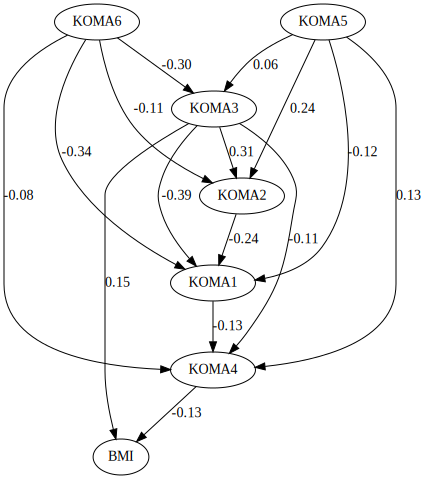

array([[0.00000000e+000, 5.05799250e-018, 5.89984706e-125,
        4.82670419e-008, 1.77151686e-003, 9.79618140e-011,
        3.50481621e-001],
       [5.05799250e-018, 0.00000000e+000, 3.28419371e-020,
        1.67845033e-004, 9.09771700e-052, 1.00513433e-016,
        2.20101281e-002],
       [5.89984706e-125, 3.28419371e-020, 0.00000000e+000,
        5.09456211e-024, 3.24824273e-010, 1.18335725e-021,
        6.23676396e-005],
       [4.82670419e-008, 1.67845033e-004, 5.09456211e-024,
        0.00000000e+000, 2.53348709e-047, 1.33991302e-002,
        2.45242570e-001],
       [1.77151686e-003, 9.09771700e-052, 3.24824273e-010,
        2.53348709e-047, 0.00000000e+000, 1.53913521e-018,
        3.34547498e-002],
       [9.79618140e-011, 1.00513433e-016, 1.18335725e-021,
        1.33991302e-002, 1.53913521e-018, 0.00000000e+000,
        9.47605234e-007],
       [3.50481621e-001, 2.20101281e-002, 6.23676396e-005,
        2.45242570e-001, 3.34547498e-002, 9.47605234e-007,
        0.00000000

因果順序
[5, 4, 2, 1, 0, 3, 6]


隣接行列


array([[ 0.        , -0.19971884, -0.45040619,  0.        , -0.1000794 ,
        -0.34542786,  0.        ],
       [ 0.        ,  0.        ,  0.36261702,  0.        ,  0.26009344,
        -0.08531256,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.11121958,
        -0.24593257,  0.        ],
       [-0.2184434 ,  0.        , -0.18370896,  0.        ,  0.13137145,
        -0.10286792,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.11000274,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.14851286, -0.20577028,  0.        ,
         0.        ,  0.        ]])

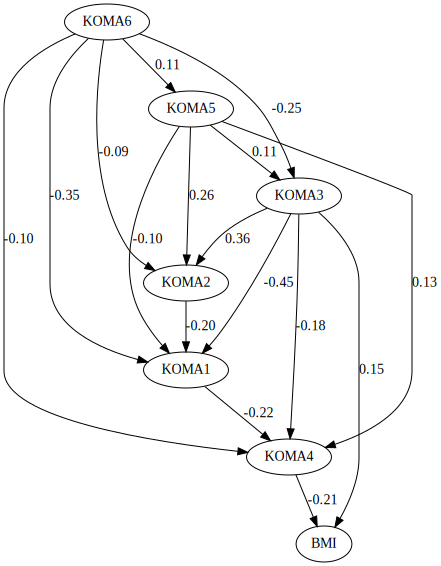

array([[0.00000000e+00, 4.41103423e-02, 9.66468918e-76, 1.40736430e-11,
        8.65427517e-02, 5.09845153e-05, 3.33660677e-08],
       [4.41103423e-02, 0.00000000e+00, 3.55468168e-14, 2.20161591e-03,
        1.67517266e-12, 3.39078715e-09, 2.22706541e-03],
       [9.66468918e-76, 3.55468168e-14, 0.00000000e+00, 2.32199116e-18,
        5.44901294e-05, 8.27180029e-08, 4.97066569e-03],
       [1.40736430e-11, 2.20161591e-03, 2.32199116e-18, 0.00000000e+00,
        5.23086813e-24, 4.44073742e-03, 2.34228269e-04],
       [8.65427517e-02, 1.67517266e-12, 5.44901294e-05, 5.23086813e-24,
        0.00000000e+00, 5.02102182e-33, 2.30275703e-01],
       [5.09845153e-05, 3.39078715e-09, 8.27180029e-08, 4.44073742e-03,
        5.02102182e-33, 0.00000000e+00, 8.90365425e-06],
       [3.33660677e-08, 2.22706541e-03, 4.97066569e-03, 2.34228269e-04,
        2.30275703e-01, 8.90365425e-06, 0.00000000e+00]])

因果順序
[5, 4, 2, 1, 0, 3, 6]


隣接行列


array([[ 0.        , -0.22861508, -0.59178791,  0.        , -0.13556726,
        -0.47879765,  0.        ],
       [ 0.        ,  0.        ,  0.28410902,  0.        ,  0.20662397,
        -0.12545633,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.36797037,  0.        ],
       [-0.27790477,  0.        , -0.25296832,  0.        ,  0.09302658,
        -0.18761697,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.16445023,  0.        ,  0.        , -0.11894675,  0.        ,
        -0.12561668,  0.        ]])

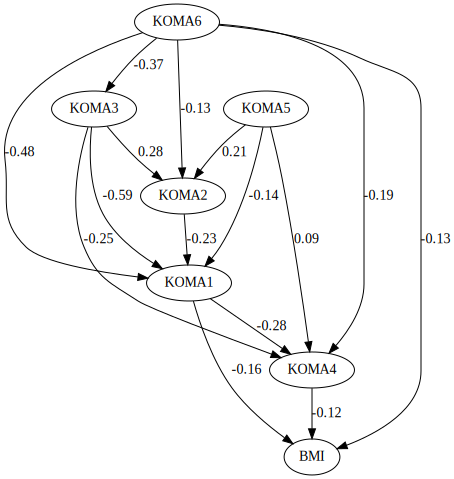

array([[0.00000000e+000, 1.10192784e-014, 3.03377474e-236,
        9.17774423e-018, 1.85768291e-001, 9.72884053e-009,
        5.06970152e-003],
       [1.10192784e-014, 0.00000000e+000, 7.03009116e-007,
        2.63070938e-001, 2.90356178e-022, 3.16546362e-007,
        9.86618036e-006],
       [3.03377474e-236, 7.03009116e-007, 0.00000000e+000,
        1.97308822e-057, 1.44407189e-005, 1.94170026e-013,
        3.10438204e-005],
       [9.17774423e-018, 2.63070938e-001, 1.97308822e-057,
        0.00000000e+000, 3.74187401e-017, 2.29448705e-004,
        9.70537445e-002],
       [1.85768291e-001, 2.90356178e-022, 1.44407189e-005,
        3.74187401e-017, 0.00000000e+000, 1.37406837e-002,
        6.25809071e-001],
       [9.72884053e-009, 3.16546362e-007, 1.94170026e-013,
        2.29448705e-004, 1.37406837e-002, 0.00000000e+000,
        3.65355640e-002],
       [5.06970152e-003, 9.86618036e-006, 3.10438204e-005,
        9.70537445e-002, 6.25809071e-001, 3.65355640e-002,
        0.00000000

In [38]:
# # マルチリンガム
model = model_MultiDirectLiNGAM(signal_data_list)

In [39]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）
pretty_causal_effects = model_MultiBootstrap(signal_data_list, 1000)
display(pretty_causal_effects)

food_bootstrap_0=============================================
因果方法top10
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA4 <--- KOMA5 (b>0) (100.0%)
KOMA2 <--- KOMA3 (b>0) (99.9%)
KOMA1 <--- KOMA5 (b<0) (99.6%)
KOMA3 <--- KOMA6 (b<0) (99.1%)
KOMA2 <--- KOMA6 (b<0) (99.0%)
KOMA2 <--- KOMA5 (b>0) (98.8%)
BMI <--- KOMA4 (b<0) (94.0%)
KOMA4 <--- KOMA1 (b<0) (92.8%)
BMI <--- KOMA3 (b>0) (92.4%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.913,0.913,0.056,0.996,1.000,0.003
KOMA2,0.087,0.000,0.999,0.002,0.988,0.990,0.003
KOMA3,0.087,0.001,0.000,0.116,0.621,0.991,0.076
KOMA4,0.928,0.072,0.847,0.000,1.000,0.813,0.060
KOMA5,0.004,0.012,0.033,0.000,0.000,0.315,0.019
KOMA6,0.000,0.010,0.009,0.000,0.100,0.000,0.002
BMI,0.076,0.030,0.924,0.940,0.384,0.460,0.000



DAGのカウント結果
DAG[0]: 11.2%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
DAG[1]: 6.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
DAG[2]: 5.4%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA3 (b

,from,to,effect,probability
0,KOMA6,KOMA1,-0.182826,1.000
1,KOMA5,KOMA4,0.143876,1.000
2,KOMA3,KOMA2,0.313007,0.999
3,KOMA5,KOMA1,-0.208186,0.996
4,KOMA6,KOMA3,-0.297196,0.991
5,KOMA6,KOMA2,-0.194236,0.990
6,KOMA5,KOMA2,0.248387,0.988
7,KOMA6,BMI,-0.082679,0.957
8,KOMA4,BMI,-0.131210,0.940
9,KOMA1,KOMA4,-0.123848,0.928


food_bootstrap_1=============================================
因果方法top10
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA2 <--- KOMA3 (b>0) (99.9%)
KOMA3 <--- KOMA6 (b<0) (99.1%)
KOMA4 <--- KOMA5 (b>0) (98.8%)
KOMA2 <--- KOMA5 (b>0) (98.8%)
KOMA1 <--- KOMA5 (b<0) (94.7%)
BMI <--- KOMA4 (b<0) (94.0%)
KOMA4 <--- KOMA1 (b<0) (93.3%)
KOMA1 <--- KOMA2 (b<0) (91.3%)
KOMA1 <--- KOMA3 (b<0) (91.3%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.913,0.913,0.056,0.947,1.000,0.001
KOMA2,0.087,0.000,0.999,0.023,0.988,0.761,0.004
KOMA3,0.087,0.001,0.000,0.109,0.805,0.991,0.067
KOMA4,0.933,0.159,0.858,0.000,0.988,0.727,0.060
KOMA5,0.004,0.012,0.046,0.000,0.000,0.672,0.011
KOMA6,0.000,0.009,0.009,0.000,0.223,0.000,0.001
BMI,0.310,0.050,0.888,0.940,0.323,0.487,0.000



DAGのカウント結果
DAG[0]: 7.6%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA5 <--- KOMA6 (b>0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
DAG[1]: 4.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA5 (b>0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	KOMA5 <--- KOMA6 (b>0)
	BMI <--- KOMA3 (b>0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[2]: 3.1%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)

,from,to,effect,probability
0,KOMA6,KOMA1,-0.218416,1.000
1,KOMA3,KOMA2,0.365138,0.999
2,KOMA5,KOMA4,0.154188,0.997
3,KOMA5,KOMA1,-0.214946,0.996
4,KOMA6,KOMA3,-0.236043,0.991
5,KOMA5,KOMA2,0.294492,0.988
6,KOMA6,KOMA2,-0.148240,0.976
7,KOMA4,BMI,-0.208909,0.940
8,KOMA1,KOMA4,-0.209678,0.933
9,KOMA3,BMI,0.158914,0.921


food_bootstrap_2=============================================
因果方法top10
KOMA1 <--- KOMA6 (b<0) (100.0%)
KOMA1 <--- KOMA5 (b<0) (99.6%)
KOMA3 <--- KOMA6 (b<0) (99.1%)
KOMA2 <--- KOMA6 (b<0) (98.9%)
KOMA2 <--- KOMA5 (b>0) (98.8%)
BMI <--- KOMA6 (b<0) (97.1%)
BMI <--- KOMA1 (b<0) (95.9%)
KOMA4 <--- KOMA5 (b>0) (95.6%)
KOMA4 <--- KOMA1 (b<0) (94.1%)
BMI <--- KOMA4 (b<0) (93.8%)

カウント確率


,KOMA1,KOMA2,KOMA3,KOMA4,KOMA5,KOMA6,BMI
KOMA1,0.000,0.913,0.913,0.056,0.996,1.000,0.041
KOMA2,0.087,0.000,0.934,0.035,0.988,0.989,0.008
KOMA3,0.087,0.001,0.000,0.108,0.115,0.991,0.006
KOMA4,0.941,0.425,0.865,0.000,0.956,0.922,0.060
KOMA5,0.004,0.012,0.009,0.000,0.000,0.011,0.002
KOMA6,0.000,0.010,0.009,0.002,0.005,0.000,0.001
BMI,0.959,0.043,0.073,0.938,0.396,0.971,0.000



DAGのカウント結果
DAG[0]: 22.6%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA2 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA1 (b<0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[1]: 18.0%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0)
	KOMA4 <--- KOMA3 (b<0)
	KOMA4 <--- KOMA5 (b>0)
	KOMA4 <--- KOMA6 (b<0)
	BMI <--- KOMA1 (b<0)
	BMI <--- KOMA4 (b<0)
	BMI <--- KOMA6 (b<0)
DAG[2]: 14.3%
	KOMA1 <--- KOMA2 (b<0)
	KOMA1 <--- KOMA3 (b<0)
	KOMA1 <--- KOMA5 (b<0)
	KOMA1 <--- KOMA6 (b<0)
	KOMA2 <--- KOMA3 (b>0)
	KOMA2 <--- KOMA5 (b>0)
	KOMA2 <--- KOMA6 (b<0)
	KOMA3 <--- KOMA6 (b<0)
	KOMA4 <--- KOMA1 (b<0

,from,to,effect,probability
0,KOMA6,KOMA1,-0.206083,1.000
1,KOMA5,KOMA4,0.140826,1.000
2,KOMA5,KOMA1,-0.195423,0.996
3,KOMA6,KOMA3,-0.368798,0.991
4,KOMA6,KOMA2,-0.231129,0.990
5,KOMA5,KOMA2,0.212624,0.988
6,KOMA1,BMI,-0.154992,0.956
7,KOMA1,KOMA4,-0.287970,0.942
8,KOMA4,BMI,-0.115544,0.934
9,KOMA3,KOMA2,0.287466,0.933


None